In [1]:
import os
os.chdir("../../scVI/")
os.getcwd()

'/data/yosef2/users/chenling/scVI'

In [2]:
import torch
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
from umap import UMAP
from sklearn.cluster import SpectralClustering
from scvi.inference import UnsupervisedTrainer
from scvi.models import VAE
save_path = '../CSF/Notebooks/'

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [3]:
from random import sample
from numpy.random import permutation


In [4]:
%matplotlib inline

In [5]:
celllabels = np.load(save_path + 'meta/celllabels.npy')
isCD4 = celllabels=='CD4'

In [6]:
clusters = np.load(save_path + 'meta/CD4.clusters.npy')

In [7]:
isMS = np.load(save_path+'meta/isMS.npy')[isCD4]
isCSF = np.load(save_path+'meta/isCSF.npy')[isCD4]

In [8]:
def ES_fast(score, s , p, interval):
    N = len(s)
    N_H = np.sum(s==1)
    m = 1/(N-N_H)
    power = np.abs(score)**p 
    N_R = np.sum(power[s==1])
    h = power / N_R
    ES = [0]
    hit = 0
    miss = 0
    for i in np.arange(0, (len(power)-interval),interval):
        x = np.arange(i,i+interval,1)
        si = s[x]
        hit = hit + np.sum(h[x][si==1])
        miss = miss + m*np.sum(si==0)
        ES.append(hit-miss)
    return(ES)

In [9]:
VisionScore = pd.read_csv('../CSF/signatures/sigScore.csv')

In [10]:
s = isMS[isCSF==True]
score = np.asarray(VisionScore['TFH'])[isCSF==True]
ranked = pd.DataFrame(np.asarray([s, score]).T,columns=['s','score'])
ranked = ranked.sample(frac=1)
ranked = ranked.sort_values(by='score',ascending=False)
s = np.asarray(ranked['s'])
score = np.asarray(ranked['score'])

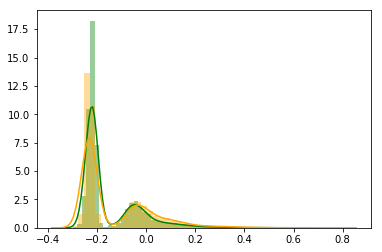

In [11]:
sns.distplot(score[s==False], kde=True, rug=False,color='green',label='control')
sns.distplot(score[s==True], kde=True, rug=False,color='orange',label='MS')
# plt.legend()
plt.savefig(save_path+'figures/SupFigure8/scoredist.MSinCSF.TFH.pdf')

In [12]:
from random import sample

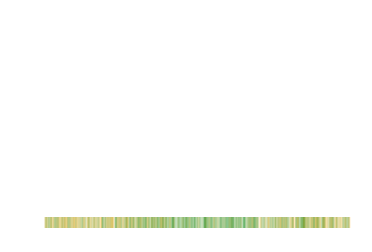

In [13]:
scorerank = np.argsort(np.argsort(score))
sns.rugplot(sample(list(scorerank[s==True]),1000), label = 'MS', color='orange', linewidth = 0.1)
sns.rugplot(sample(list(scorerank[s==False]),1000), label = 'Control', color = 'green', linewidth = 0.1)
plt.axis('off')
# plt.legend()
plt.savefig(save_path+'figures/SupFigure8/rugplot.MSinCSF.TFH.pdf')

In [14]:
ES = ES_fast(score,s,1,1)

In [15]:
from random import sample

In [16]:
control = [ES_fast(score,np.asarray(sample(list(s),len(s))),1,1) for i in range(100)]

In [17]:
control_score = pd.read_csv('../CSF/signatures/sigScore.TFH.matched.csv')
control_score = control_score.loc[isCSF==True]
control_score = control_score[control_score.columns[1:]]
control_score.loc[:5]

,random0,random1,random2,random3,random4,random5,random6,random7,random8,random9,...,random990,random991,random992,random993,random994,random995,random996,random997,random998,random999
0,-0.221594,-0.221594,-0.221594,-0.221594,-0.221594,-0.221594,-0.221594,-0.017873,-0.221594,-0.017873,...,-0.017873,-0.221594,-0.221594,-0.221594,-0.017873,-0.221594,-0.017873,-0.221594,-0.221594,-0.221594
1,-0.221594,-0.221594,-0.221594,-0.086295,-0.221594,-0.086295,-0.086295,-0.221594,-0.221594,-0.221594,...,-0.221594,-0.221594,-0.221594,-0.221594,-0.086295,-0.086295,-0.221594,-0.221594,-0.086295,-0.086295
2,-0.233791,-0.233791,-0.233791,-0.233791,-0.233791,-0.100345,-0.233791,0.134567,-0.100345,-0.233791,...,-0.233791,-0.100345,-0.100345,-0.233791,-0.233791,-0.100345,-0.233791,-0.100345,-0.100345,-0.233791
3,-0.258078,-0.258078,-0.161773,-0.065468,-0.258078,0.030837,-0.258078,-0.161773,-0.258078,-0.083054,...,0.030837,-0.161773,-0.258078,-0.258078,-0.065468,-0.258078,-0.161773,-0.258078,-0.065468,0.030837
4,-0.111112,-0.221855,-0.111112,-0.000370,-0.221855,-0.221855,-0.221855,-0.221855,-0.221855,-0.221855,...,-0.221855,-0.221855,-0.111112,-0.221855,-0.221855,-0.221855,-0.221855,-0.023499,-0.000370,-0.023499
5,-0.225346,-0.049978,-0.225346,0.125390,0.125390,-0.225346,-0.049978,-0.225346,-0.049978,0.125390,...,-0.225346,-0.049978,-0.225346,-0.225346,0.125390,-0.049978,-0.225346,-0.049978,-0.049978,-0.225346


In [18]:
control2 = []
for x in control_score.columns:
    score = control_score[x]
    ranked = pd.DataFrame(np.asarray([s, score]).T,columns=['s','score'])
    ranked = ranked.sample(frac=1)
    ranked = ranked.sort_values(by='score',ascending=False)
    s = np.asarray(ranked['s'])
    score = np.asarray(ranked['score'])
    control2.append(ES_fast(score,s,1,1))

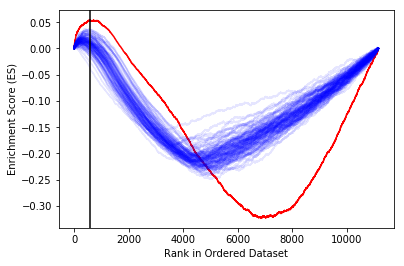

In [19]:
plt.plot(np.arange(len(ES)),ES,'r-')
for i in range(100):
    plt.plot(np.arange(len(ES)),control2[i],'b-',alpha=0.1)


plt.axvline(x=np.argmax(ES),color='black')
# plt.title("Diseased Cell Set")
plt.xlabel("Rank in Ordered Dataset")
plt.ylabel("Enrichment Score (ES)")
plt.savefig(save_path+'figures/SupFigure8/ES.MSinCSF.TFH.pdf')

In [20]:
with open(save_path + 'CSEA/TFH.MSinCSF.pkl', 'wb') as f:
    pickle.dump((ES,control2), f)


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


### Pvalue

In [21]:
np.mean(np.asarray([np.max(x) for x in control2[1:]]) > np.max(ES))

0.0

### Leading Edge

In [22]:
np.argmax(ES)

587

# in blood

In [23]:
s = isMS[isCSF==False]
score = np.asarray(VisionScore['TFH'])[isCSF==False]
ranked = pd.DataFrame(np.asarray([s, score]).T,columns=['s','score'])
ranked = ranked.sample(frac=1)
ranked = ranked.sort_values(by='score',ascending=False)
s = np.asarray(ranked['s'])
score = np.asarray(ranked['score'])

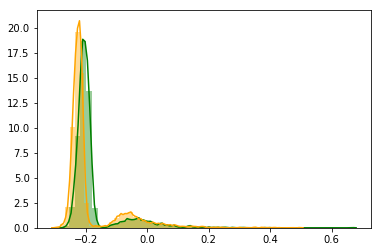

In [24]:
sns.distplot(score[s==False], kde=True, rug=False,color='green',label='control')
sns.distplot(score[s==True], kde=True, rug=False,color='orange',label='MS')
# plt.legend()
plt.savefig(save_path+'figures/SupFigure8/scoredist.MSinPBMC.TFH.pdf')

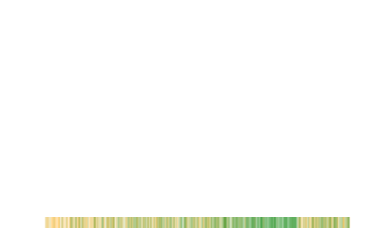

In [25]:
scorerank = np.argsort(np.argsort(score))
sns.rugplot(sample(list(scorerank[s==True]),1000), label = 'MS', color='orange', linewidth = 0.1)
sns.rugplot(sample(list(scorerank[s==False]),1000), label = 'Control', color = 'green', linewidth = 0.1)
plt.axis('off')
# plt.legend()
plt.savefig(save_path+'figures/SupFigure8/rugplot.MSinPBMC.TFH.pdf')

In [26]:
ES = ES_fast(score,s,1,1)

In [27]:
from random import sample

In [28]:
control = [ES_fast(score,np.asarray(sample(list(s),len(s))),1,1) for i in range(100)]

In [29]:
control_score = pd.read_csv('../CSF/signatures/sigScore.TFH.matched.csv')
control_score = control_score.loc[isCSF==False]
control_score = control_score[control_score.columns[1:]]

In [30]:
control2 = []
for x in control_score.columns:
    score = control_score[x]
    ranked = pd.DataFrame(np.asarray([s, score]).T,columns=['s','score'])
    ranked = ranked.sample(frac=1)
    ranked = ranked.sort_values(by='score',ascending=False)
    s = np.asarray(ranked['s'])
    score = np.asarray(ranked['score'])
    control2.append(ES_fast(score,s,1,1))

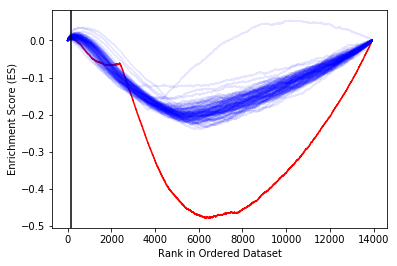

In [31]:
plt.plot(np.arange(len(ES)),ES,'r-')
for i in range(100):
    plt.plot(np.arange(len(ES)),control2[i],'b-',alpha=0.1)

plt.axvline(x=np.argmax(ES),color='black')
# plt.title("Diseased Cell Set")
plt.xlabel("Rank in Ordered Dataset")
plt.ylabel("Enrichment Score (ES)")
plt.savefig(save_path+'figures/SupFigure8/ES.MSinPBMC.TFH.pdf')

# Significance value 
0.889 in blood
0.002 in CSF

In [32]:
np.mean(np.asarray([np.max(x) for x in control2]) > np.max(ES))

0.887

### Leading Edge

In [33]:
np.argmax(ES)

135

# show TFH cell origins

In [34]:
latent_u = np.load(save_path + 'UMAP/all_dataset.umap.npy')
celllabels = np.load(save_path + 'meta/celllabels.npy')
celltype, labels = np.unique(celllabels, return_inverse=True)
isMS = np.load(save_path+'meta/isMS.npy')
isCSF = np.load(save_path+'meta/isCSF.npy')
validclusters = (celllabels!='Mono Doublet') & \
(celllabels!='contamination1') & \
(celllabels!='doublet') & \
(celllabels!='B cell doublets') & \
(celllabels!='RBC')
isCD4 = (celllabels=='CD4')

In [35]:
latent_u = latent_u[celllabels=='CD4',:]
isMS = isMS[celllabels=='CD4']
isCSF = isCSF[celllabels=='CD4']

In [36]:
edgethres = np.quantile(VisionScore['TFH'],(1-(587+135)/25105))

In [37]:
TFH = np.asarray(VisionScore['TFH']>edgethres)

In [38]:
len(isCSF)

25105

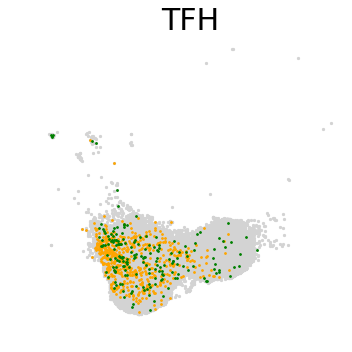

In [39]:
fig, ax = plt.subplots(figsize=(5, 5),facecolor='white')
plt.scatter(latent_u[:, 0], latent_u[:, 1],c='lightgray',s=5)
plt.scatter(latent_u[:, 0][TFH & isCSF], latent_u[:, 1][TFH & isCSF],c='orange',s=3,label='CSF')
plt.scatter(latent_u[:, 0][TFH & (isCSF==False)], latent_u[:, 1][TFH & (isCSF==False)],c='green',s=3,label='PBMC')
plt.title('TFH',fontsize=30)
plt.axis("off")
# plt.legend()
plt.tight_layout()
plt.savefig(save_path+'figures/SupFigure8/TFH.CSF_PBMC.pdf')

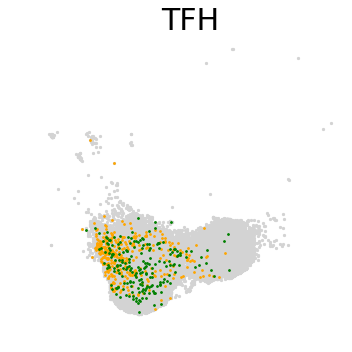

In [40]:
fig, ax = plt.subplots(figsize=(5, 5),facecolor='white')
plt.scatter(latent_u[:, 0], latent_u[:, 1],c='lightgray',s=5)
plt.scatter(latent_u[:, 0][TFH & isCSF & isMS], latent_u[:, 1][TFH & isCSF & isMS],c='orange',s=3,label='MS')
plt.scatter(latent_u[:, 0][TFH & isCSF & (isMS==False)], latent_u[:, 1][TFH & isCSF & (isMS==False)],c='green',s=3,label='control')
plt.title('TFH',fontsize=30)
plt.axis("off")
# plt.legend()
plt.tight_layout()
plt.savefig(save_path+'figures/SupFigure8/TFH.MSinCSF.pdf')

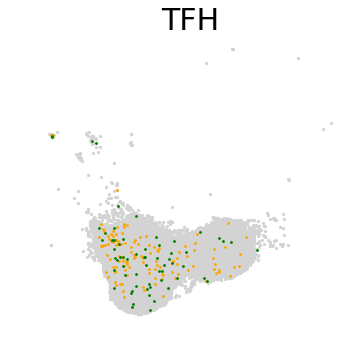

In [41]:
fig, ax = plt.subplots(figsize=(5, 5),facecolor='white')
plt.scatter(latent_u[:, 0], latent_u[:, 1],c='lightgray',s=5)
plt.scatter(latent_u[:, 0][TFH & (isCSF==False) & isMS], latent_u[:, 1][TFH & (isCSF==False) & isMS],c='orange',s=3,label='MS')
plt.scatter(latent_u[:, 0][TFH & (isCSF==False) & (isMS==False)], latent_u[:, 1][TFH & (isCSF==False) & (isMS==False)],c='green',s=3,label='control')
plt.title('TFH',fontsize=30)
plt.axis("off")
# plt.legend()
plt.tight_layout()
plt.savefig(save_path+'figures/SupFigure8/TFH.MSinPBMC.pdf')